# 05. Modelling and evaluation

## Business Requirements (scope of this notebook)
- **BR2:** Build and evaluate a **fair and interpretable CEFR classifier** using **engineered (leakage-free) features only**, meeting predefined targets and evidencing fairness across CEFR levels.

## Objectives
- Train and tune multiple classifiers (e.g., Logistic Regression, Random Forest, XGBoost) **on engineered features only**.  
- Use **Accuracy, Macro-F1, Weighted-F1**, the **classification report**, and the **confusion matrix** for evaluation on the **test set**.  
- Use **5-fold cross-validation** to check generalisation.  
- Compare tuned models and **select a final model** that meets targets (e.g., **Accuracy ≥ 0.78**, **Macro-F1 ≥ 0.72**).  
- **Save the final pipeline** for deployment (Streamlit).

## Inputs
- Engineered feature matrix `X` and target `y` from the Feature Engineering notebook.  
- Saved train/test split artefacts (if applicable).

## Outputs
- Tuned models and a **test-set comparison table** of key metrics.  
- Confusion matrix and per-class F1 scores for the final model.  
- Cross-validation summary (out-of-sample estimates).  
- **Statement of success** vs targets and **saved final pipeline** for inference.

## Additional Information
- This notebook **fulfils BR2**: it demonstrates that a model trained on **leakage-free engineered features** is **accurate, fair (Macro-F1),** and **deployable**.

---

# Project Directory Structure

## Change working directory

We need to change the working directory from its current folder to the folder the code of this project is currently located

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\husse\\OneDrive\\Projects\\lang-level-pred\\jupyter_notebooks'

In [2]:
from pathlib import Path

# swtich to project root directory
project_root = Path.cwd().parent
os.chdir(project_root)
print(f"Working directory: {os.getcwd()}")

Working directory: c:\Users\husse\OneDrive\Projects\lang-level-pred


---

# Data loading
This code block imports fundamental Python libraries for data analysis and visualization and checks their versions

- pandas: For data manipulation and analysis
- numpy: For numerical computations
- matplotlib: For creating visualizations and plots
- seaborn: creating attractive and informative statistical graphics from datasets

The version checks help ensure:
- Code compatibility across different environments
- Reproducibility of analysis
- Easy debugging of version-specific issues

In [3]:
# Import data analysis tools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


print(f"pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")

pandas version: 2.3.1
NumPy version: 2.3.1
matplotlib version: 3.10.5
seaborn version: 0.13.2


### List Files and Folders
- This code shows what files and folders are in our data/clean folder and what folder we are currently in. 

In [5]:
import os
from pathlib import Path

dataset_dir = Path("data/processed")
print(f"[INFO] Files/folders available in {dataset_dir}:")
os.listdir(dataset_dir)

[INFO] Files/folders available in data\processed:


['features.csv', 'target.csv']

## Load Processed Data

In this step, we will load the processed dataset that was prepared in the Feature Engineering Notebook.  
The data has been saved in two separate files:

- `features.csv` → contains the engineered and scaled features.  
- `target.csv` → contains the encoded CEFR levels.  

We will:
- Load both files.  
- Inspect their structure (rows, columns, datatypes).  
- Confirm they align correctly (same number of rows).  
- Prepare them as `X` (features) and `y` (target) for model training.    

In [228]:
import pandas as pd

# Load processed features and target
X = pd.read_csv("data/processed/features.csv")
y = pd.read_csv("data/processed/target.csv").squeeze()  # convert to Series

# ✅ Drop avg_score from features
if "avg_score" in X.columns:
    X = X.drop(columns=["avg_score"])

# Inspect shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Preview
print("\nFeature columns:\n", X.columns.tolist())
print("\nTarget preview:\n", y.head())

# Validate alignment
assert X.shape[0] == y.shape[0], "❌ Row mismatch between features and target!"
print("✅ Features and target aligned correctly.")

Features shape: (1004, 14)
Target shape: (1004,)

Feature columns:
 ['strongest_skill', 'weakest_skill', 'second_weakest_skill', 'strength_weakness_gap', 'learning_profile', 'speaking_minus_avg', 'reading_minus_avg', 'listening_minus_avg', 'writing_minus_avg', 'productive_dominant', 'speaking_level', 'reading_level', 'listening_level', 'writing_level']

Target preview:
 0    0
1    4
2    2
3    2
4    3
Name: cefr_encoded, dtype: int64
✅ Features and target aligned correctly.


---

## 1. Define Features and Target

Now that we have successfully loaded the processed dataset, we need to separate it into:

- **X (features):** all engineered and scaled variables used by the model to make predictions.  
- **y (target):** the encoded CEFR levels that the model will learn to predict.  

We will confirm that both `X` and `y` are correctly structured and aligned before proceeding to train/test splitting.

In [229]:
# Confirm feature matrix (X) and target vector (y)

print("Feature matrix (X):")
print(X.head())

print("\nTarget vector (y):")
print(y.head())

print("\nShapes:")
print("X:", X.shape)
print("y:", y.shape)

Feature matrix (X):
  strongest_skill weakest_skill second_weakest_skill  strength_weakness_gap  \
0         reading      speaking            listening               1.427690   
1        speaking       writing            listening              -1.225282   
2         reading       writing             speaking               0.101204   
3        speaking     listening            listening               0.101204   
4       listening       reading             speaking               0.631798   

     learning_profile  speaking_minus_avg  reading_minus_avg  \
0  Uneven Development           -2.069500           1.751171   
1            Balanced            0.609820           0.058795   
2            Balanced            0.197617           0.735745   
3            Balanced            1.502926           0.397270   
4            Balanced           -0.077185          -1.430496   

   listening_minus_avg  writing_minus_avg  productive_dominant speaking_level  \
0            -0.421848           0.7207

## 2. Train/Test Split with One-Hot Encoding

In this step, we:

- Split the dataset into **training** and **testing** sets using stratified sampling to preserve the CEFR class distribution.  
- Identified categorical engineered features:  
  - `strongest_skill`  
  - `weakest_skill`  
  - `second_weakest_skill`  
  - `learning_profile`  
- Identified numeric engineered features:  
  - `skill_std`  
  - `strength_weakness_gap`  
  - `productive_receptive_ratio`  
  - `speaking_minus_avg`  
  - `reading_minus_avg`  
  - `listening_minus_avg`  
  - `writing_minus_avg`  
  - `speaking_to_reading`  
  - `writing_to_listening`  
- Applied **One-Hot Encoding (OHE)** to categorical variables (dropping the first category to avoid multicollinearity).  
- Kept numeric features as-is (passthrough).  
- Verified dataset sizes before and after preprocessing. 

In [230]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify categorical and numeric features
categorical_features = ["strongest_skill", "weakest_skill", "second_weakest_skill", "learning_profile", "reading_level", "listening_level", "speaking_level", "writing_level"]
numeric_features = [col for col in X.columns if col not in categorical_features]

print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)

# Define preprocessing: One-Hot Encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

# Split the dataset (stratify ensures CEFR balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Fit and transform training set, transform test set
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed training set shape:", X_train_processed.shape)
print("Processed test set shape:", X_test_processed.shape)

Categorical features: ['strongest_skill', 'weakest_skill', 'second_weakest_skill', 'learning_profile', 'reading_level', 'listening_level', 'speaking_level', 'writing_level']
Numeric features: ['strength_weakness_gap', 'speaking_minus_avg', 'reading_minus_avg', 'listening_minus_avg', 'writing_minus_avg', 'productive_dominant']
Training set size: (803, 14)
Test set size: (201, 14)
Processed training set shape: (803, 24)
Processed test set shape: (201, 24)


## 3. Model Training (Baseline)

In this step, we will train an initial **baseline machine learning model** to predict the CEFR level.

- **Why Logistic Regression?**  
  Logistic Regression is a simple, interpretable classifier that works well as a starting point for multi-class classification. It provides a benchmark for accuracy and helps us understand whether more complex models are needed.

- **Process:**
  1. Use the preprocessed feature set (`X_train_processed`, `X_test_processed`).
  2. Train a **Logistic Regression model** with multi-class handling (`multinomial`).
  3. Evaluate performance on the test set using:
     - Accuracy
     - Classification report (precision, recall, F1-score per class)
     - Confusion matrix (to visualize misclassifications)

This baseline performance will serve as a reference point for future, more advanced models.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


# Build pipeline: scaling + logistic regression
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False to work with sparse data from OneHotEncoder
    ("log_reg", LogisticRegression(solver="lbfgs", max_iter=2000, random_state=42))
])

# Train model
log_reg_pipeline.fit(X_train_processed, y_train)

# Predictions
y_pred = log_reg_pipeline.predict(X_test_processed)

# Evaluation
print("✅ Logistic Regression Baseline Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))




✅ Logistic Regression Baseline Results
Accuracy: 0.7960199004975125

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.77      1.00      0.87        44
           2       1.00      0.71      0.83        42
           3       0.83      0.79      0.81        38
           4       0.38      0.32      0.34        19
           5       0.45      0.62      0.53        16

    accuracy                           0.80       201
   macro avg       0.74      0.73      0.73       201
weighted avg       0.82      0.80      0.80       201



## 4. Model: Random Forest Classifier  

We now train a **Random Forest Classifier** as one of our core models.  
Random Forests are an ensemble of decision trees, which makes them effective at capturing non-linear relationships and feature interactions.  

Key reasons for using Random Forest:  
- They handle both categorical (OHE-encoded) and numeric features effectively.  
- They are robust to overfitting compared to individual decision trees.  
- They can provide feature importance estimates to understand which variables drive predictions.  

The pipeline includes:  
1. **Preprocessing** → one-hot encoding for categorical features and passthrough for numeric features.  
2. **Classification** → Random Forest with 200 estimators and a fixed random state for reproducibility.  

We then evaluate the model using:  
- **Accuracy** (overall correctness)  
- **Classification report** (precision, recall, F1-score per CEFR level)  
- **Confusion matrix** (visualising misclassifications across levels) 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, f1_score


# Random Forest pipeline
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight="balanced"
    ))
])

# Train
rf_clf.fit(X_train, y_train)

# Predict
y_pred = rf_clf.predict(X_test)

# Results
print("✅ Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Random Forest Results
Accuracy: 0.736318407960199

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.81      0.89      0.85        44
           2       0.84      0.76      0.80        42
           3       0.79      0.68      0.73        38
           4       0.23      0.26      0.24        19
           5       0.32      0.38      0.34        16

    accuracy                           0.74       201
   macro avg       0.66      0.65      0.66       201
weighted avg       0.75      0.74      0.74       201



## 5. Model: XGBoost Classifier  

Next, we train an **XGBoost Classifier**, a gradient boosting algorithm that is highly effective for multi-class classification tasks like CEFR prediction.  

Key reasons for using XGBoost:  
- Captures **non-linear relationships** and complex feature interactions.  
- Well-suited for structured/tabular data and often achieves state-of-the-art results.  
- Includes **regularization** terms to reduce overfitting.  
- Can handle class imbalance when tuned with appropriate parameters.  

Configuration used:  
- `n_estimators=300` → number of boosting rounds.  
- `learning_rate=0.1` → controls contribution of each tree.  
- `max_depth=6` → maximum depth of each tree (controls complexity).  
- `eval_metric="mlogloss"` → multi-class log loss for evaluation during training.  

The pipeline includes:  
1. **Preprocessing** → one-hot encoding for categorical features and passthrough for numeric features.  
2. **Classification** → XGBoost model with the above hyperparameters.  

We then evaluate performance using:  
- **Accuracy** (overall correctness)  
- **Classification report** (precision, recall, F1-score per CEFR level)  
- **Confusion matrix** (to analyse misclassifications)  

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

xgb_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss"
    ))
])

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

print("✅ XGBoost Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


c:\Users\husse\OneDrive\Projects\lang-level-pred\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:15:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Results
Accuracy: 0.7263681592039801

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94        42
           1       0.83      0.80      0.81        44
           2       0.78      0.76      0.77        42
           3       0.74      0.66      0.69        38
           4       0.32      0.42      0.36        19
           5       0.38      0.38      0.38        16

    accuracy                           0.73       201
   macro avg       0.66      0.66      0.66       201
weighted avg       0.74      0.73      0.73       201



## 6. Hyperparameter Tuning: Logistic Regression (with Class Imbalance Handling)  

While the baseline Logistic Regression model provides a strong benchmark, its performance can be further improved through **hyperparameter tuning**.  
Because the dataset shows **class imbalance across CEFR levels**, we tune both **regularization strength** and **penalty type**, while also considering **class weighting**.  

### Key tuning strategies  
- **Regularization strength (`C`)** → balances underfitting (small `C`) and overfitting (large `C`).  
- **Penalty type (`l1`, `l2`, `elasticnet`)** → explores sparsity (L1), smoothness (L2), or a combination.  
- **Elastic Net mixing (`l1_ratio`)** → balances L1 and L2 penalties for flexible feature selection.  
- **Class weighting (`balanced`)** → adjusts weights inversely to class frequencies, ensuring minority CEFR levels are not overlooked.  

We apply **GridSearchCV** to systematically evaluate parameter combinations, using **macro-F1** as the scoring metric to ensure fair performance across all CEFR levels, regardless of class imbalance.  

In [249]:
# Hyperparameter tuning for Logistic Regression (GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib   # for saving model if desired

# Pipeline: scaler (with_mean=False for sparse) + logistic regression
pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("log_reg", LogisticRegression(
        multi_class="multinomial",
        solver="saga",        # saga supports l1, l2, elasticnet with multinomial
        max_iter=5000,
        random_state=42,
        n_jobs=-1
    ))
])

# Parameter grid
param_grid = {
    # regularization strength
    "log_reg__C": [0.01, 0.1, 1, 10, 100],
    # penalty types to try
    "log_reg__penalty": ["l2", "l1", "elasticnet"],
    # l1_ratio is only used if penalty='elasticnet' (ignored otherwise)
    "log_reg__l1_ratio": [0.0, 0.5],   # 0.0==l2, 0.5==mixed
    # optional: deal with class imbalance
    "log_reg__class_weight": [None, "balanced"]
}

# GridSearchCV: optimize macro-F1 (sensible for class imbalance / multiclass)
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit (this may take a while depending on dataset size)
grid.fit(X_train_processed, y_train)

# Best params & CV score
print("✅ Best params:", grid.best_params_)
print("✅ Best CV f1_macro:", grid.best_score_)

# Evaluate best estimator on the test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_processed)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# save the tuned pipeline
joblib.dump(best_model, "logreg_tuned_pipeline.joblib")
print("Saved tuned model to logreg_tuned_pipeline.joblib")


Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\husse\OneDrive\Projects\lang-level-pred\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\husse\OneDrive\Projects\lang-level-pred\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Best params: {'log_reg__C': 1, 'log_reg__class_weight': 'balanced', 'log_reg__l1_ratio': 0.0, 'log_reg__penalty': 'l1'}
✅ Best CV f1_macro: 0.7051603465359206

Test Accuracy: 0.7711442786069652

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.77      1.00      0.87        44
           2       1.00      0.69      0.82        42
           3       0.90      0.68      0.78        38
           4       0.29      0.21      0.24        19
           5       0.38      0.75      0.50        16

    accuracy                           0.77       201
   macro avg       0.72      0.71      0.70       201
weighted avg       0.81      0.77      0.77       201

Saved tuned model to logreg_tuned_pipeline.joblib


## 7. Hyperparameter Tuning: Random Forest Classifier (with Class Imbalance Handling)  

While the baseline Random Forest provides a strong non-linear model, its performance can be improved through **hyperparameter tuning**.  
Because the dataset shows **class imbalance across CEFR levels**, we focus on parameters that control model complexity and weighting of classes.  

### Key tuning strategies  
- **Number of trees (`n_estimators`)** → more trees generally improve stability and reduce variance.  
- **Maximum depth (`max_depth`)** → limits the complexity of individual trees, helping to prevent overfitting.  
- **Class weighting (`class_weight`)** → e.g., `balanced` adjusts weights inversely to class frequencies, ensuring minority CEFR levels are considered fairly.  

We apply **GridSearchCV** to systematically evaluate parameter combinations, using **macro-F1** as the scoring metric to ensure balanced performance across all CEFR levels.  

This tuning step helps Random Forest generalise better, controlling overfitting while also addressing class imbalance in the dataset.  

In [248]:
# Hyperparameter tuning for Random Forest (GridSearchCV)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Pipeline (just the model, since RF handles numeric/categorical OHE directly if preprocessed)
rf_pipeline = Pipeline([
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Parameter grid (kept small & sensible)
rf_param_grid = {
    "rf__n_estimators": [200, 300, 500],
    "rf__max_depth": [None, 10, 20],
    "rf__class_weight": [None, "balanced"]
}

# GridSearchCV: optimise macro-F1
rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit
rf_grid.fit(X_train_processed, y_train)

# Best params & CV score
print("✅ Best params (RF):", rf_grid.best_params_)
print("✅ Best CV f1_macro (RF):", rf_grid.best_score_)

# Evaluate best estimator on the test set
rf_best_model = rf_grid.best_estimator_
rf_y_pred = rf_best_model.predict(X_test_processed)

print("\nTest Accuracy (RF):", accuracy_score(y_test, rf_y_pred))
print("\nClassification Report (RF):\n", classification_report(y_test, rf_y_pred))


# Save the tuned pipeline
joblib.dump(rf_best_model, "random_forest_tuned_pipeline.joblib")
print("Saved tuned model to random_forest_tuned_pipeline.joblib")



Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ Best params (RF): {'rf__class_weight': 'balanced', 'rf__max_depth': 10, 'rf__n_estimators': 300}
✅ Best CV f1_macro (RF): 0.7088437428125592

Test Accuracy (RF): 0.7313432835820896

Classification Report (RF):
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.79      0.95      0.87        44
           2       0.88      0.71      0.79        42
           3       0.92      0.63      0.75        38
           4       0.18      0.21      0.20        19
           5       0.27      0.44      0.33        16

    accuracy                           0.73       201
   macro avg       0.67      0.65      0.65       201
weighted avg       0.78      0.73      0.75       201

Saved tuned model to random_forest_tuned_pipeline.joblib


## 8. Hyperparameter Tuning: XGBoost Classifier (with Class Imbalance Handling)  

While the baseline XGBoost model already provides strong predictive power, its performance can be further improved through **hyperparameter tuning**.  
Because the dataset shows **class imbalance across CEFR levels**, we focus on parameters that balance model complexity, learning rate, and sampling strategies.  

### Key tuning strategies  
- **Number of trees (`n_estimators`)** → controls the number of boosting rounds; more trees can capture more patterns but risk overfitting.  
- **Maximum depth (`max_depth`)** → limits the complexity of individual trees to improve generalisation.  
- **Learning rate (`learning_rate`)** → shrinks the contribution of each tree, balancing underfitting and overfitting.  
- **Subsampling (`subsample`)** → uses a fraction of the data per boosting round to reduce variance.  
- **Column sampling (`colsample_bytree`)** → randomly selects a subset of features for each tree, improving robustness.  

We apply **GridSearchCV** to systematically evaluate parameter combinations, using **macro-F1** as the scoring metric to ensure balanced performance across all CEFR levels.  

This tuning step helps XGBoost achieve a better balance of **accuracy, fairness across classes, and generalisation**, while controlling the risk of overfitting.  

In [247]:
# Hyperparameter tuning for XGBoost (GridSearchCV)
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Pipeline (just the model, since preprocessing was already handled)
xgb_pipeline = Pipeline([
    ("xgb", XGBClassifier(
        objective="multi:softmax",   # predict class labels directly
        num_class=len(set(y_train)), # number of CEFR levels
        random_state=42,
        n_jobs=-1,
        eval_metric="mlogloss",
        use_label_encoder=False
    ))
])

# Parameter grid (kept small but meaningful)
xgb_param_grid = {
    "xgb__n_estimators": [200, 300],
    "xgb__max_depth": [4, 6],
    "xgb__learning_rate": [0.05, 0.1],
    "xgb__subsample": [0.8, 1.0],
    "xgb__colsample_bytree": [0.8, 1.0]
}

# GridSearchCV: optimise macro-F1
xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit
xgb_grid.fit(X_train_processed, y_train)

# Best params & CV score
print("✅ Best params (XGB):", xgb_grid.best_params_)
print("✅ Best CV f1_macro (XGB):", xgb_grid.best_score_)

# Evaluate best estimator on the test set
xgb_best_model = xgb_grid.best_estimator_
xgb_y_pred = xgb_best_model.predict(X_test_processed)

print("\nTest Accuracy (XGB):", accuracy_score(y_test, xgb_y_pred))
print("\nClassification Report (XGB):\n", classification_report(y_test, xgb_y_pred))

# Save the tuned pipeline
joblib.dump(xgb_best_model, "xgboost_tuned_pipeline.joblib")
print("Saved tuned model to xgboost_tuned_pipeline.joblib")



Fitting 5 folds for each of 32 candidates, totalling 160 fits


c:\Users\husse\OneDrive\Projects\lang-level-pred\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best params (XGB): {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 4, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
✅ Best CV f1_macro (XGB): 0.6807387976590374

Test Accuracy (XGB): 0.7611940298507462

Classification Report (XGB):
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.80      0.89      0.84        44
           2       0.84      0.74      0.78        42
           3       0.84      0.71      0.77        38
           4       0.33      0.42      0.37        19
           5       0.44      0.50      0.47        16

    accuracy                           0.76       201
   macro avg       0.71      0.70      0.70       201
weighted avg       0.78      0.76      0.77       201

Saved tuned model to xgboost_tuned_pipeline.joblib


## 9. Cross-Validation: Logistic Regression (Out-of-Sample Evaluation)  

To ensure the tuned Logistic Regression model generalises well and is not overfitting the training data, we perform **cross-validation** using `cross_val_predict`.  
This approach generates **out-of-sample predictions for each fold**, giving a more realistic estimate of model performance than in-sample evaluation.  

### Key evaluation steps  
- **5-Fold Cross-Validation** → train on 80% of the data and validate on 20%, repeated across folds.  
- **Macro-F1 scoring** → chosen to ensure balanced performance across all CEFR levels, even under class imbalance.  
- **Confusion matrix** → visualises per-class errors and highlights where misclassifications occur.  

This confirms that the Logistic Regression model delivers **consistent and reliable performance** across different splits of the dataset, making it suitable for deployment.  


📊 Cross-Fitting Results (Training Data, Out-of-Sample)
Accuracy: 0.772104607721046

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96       166
           1       0.75      0.98      0.85       175
           2       0.96      0.69      0.80       166
           3       0.84      0.75      0.79       154
           4       0.44      0.45      0.44        75
           5       0.36      0.48      0.41        67

    accuracy                           0.77       803
   macro avg       0.73      0.71      0.71       803
weighted avg       0.80      0.77      0.78       803



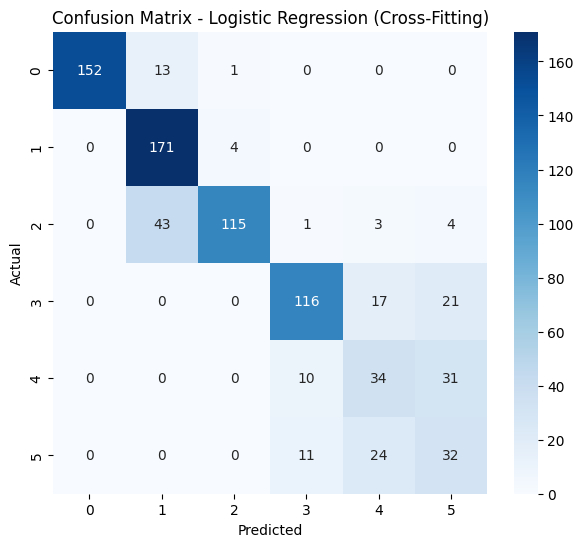

In [225]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cross-fitting predictions on training set
y_train_pred = cross_val_predict(best_model, X_train_processed, y_train, cv=5, n_jobs=-1)

print("\n📊 Cross-Fitting Results (Training Data, Out-of-Sample)")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))

cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.named_steps["log_reg"].classes_,
            yticklabels=best_model.named_steps["log_reg"].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Cross-Fitting)")
plt.show()


## 10. Cross-Validation: Random Forest (Out-of-Sample Evaluation)  

To check whether the tuned Random Forest model generalises well and does not overfit the training data, we perform **cross-validation** using `cross_val_predict`.  
This generates **out-of-sample predictions for each fold**, giving a more realistic estimate of model performance than in-sample evaluation.  

### Key evaluation steps  
- **5-Fold Cross-Validation** → train on 80% of the data and validate on 20%, repeated across folds.  
- **Macro-F1 scoring** → chosen to ensure balanced performance across all CEFR levels, even under class imbalance.  
- **Confusion matrix** → visualises per-class errors and highlights where misclassifications occur.  

This confirms that the Random Forest model provides **stable performance across folds**, though with slightly lower macro-F1 compared to Logistic Regression. This suggests that while Random Forest can capture non-linear relationships, it may be more affected by class imbalance.  

Cross-Validated Accuracy (RF): 0.772104607721046
Cross-Validated Macro-F1 (RF): 0.7103658624302085

Classification Report (RF, CV):
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       166
           1       0.76      0.95      0.85       175
           2       0.92      0.73      0.82       166
           3       0.89      0.73      0.80       154
           4       0.41      0.53      0.46        75
           5       0.36      0.40      0.38        67

    accuracy                           0.77       803
   macro avg       0.72      0.71      0.71       803
weighted avg       0.80      0.77      0.78       803



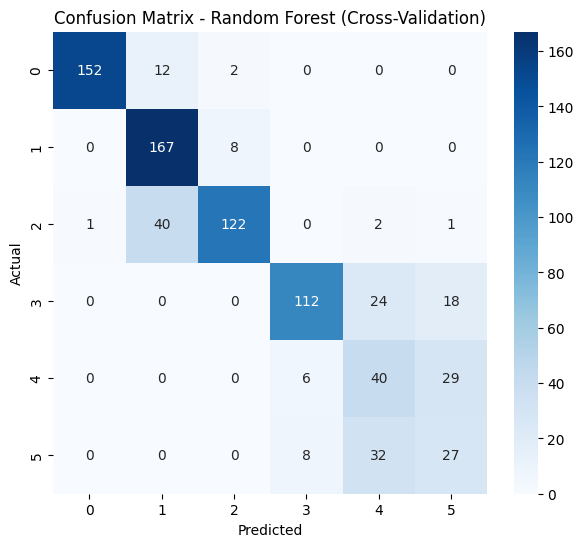

In [226]:
# Cross-Validation: Random Forest (Out-of-Sample Evaluation)
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Use the tuned Random Forest model from GridSearchCV
rf_best_model = rf_grid.best_estimator_

# Generate cross-validated predictions
rf_cv_pred = cross_val_predict(
    rf_best_model, X_train_processed, y_train, cv=5, n_jobs=-1
)

# Evaluation metrics
print("Cross-Validated Accuracy (RF):", accuracy_score(y_train, rf_cv_pred))
print("Cross-Validated Macro-F1 (RF):", f1_score(y_train, rf_cv_pred, average="macro"))
print("\nClassification Report (RF, CV):\n", classification_report(y_train, rf_cv_pred))

# Confusion matrix
rf_cv_cm = confusion_matrix(y_train, rf_cv_pred)
plt.figure(figsize=(7,6))
sns.heatmap(rf_cv_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf_best_model.named_steps["rf"].classes_,
            yticklabels=rf_best_model.named_steps["rf"].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest (Cross-Validation)")
plt.show()


## 11. Cross-Validation: XGBoost (Out-of-Sample Evaluation)  

To ensure the tuned XGBoost model generalises well and is not overfitting the training data, we perform **cross-validation** using `cross_val_predict`.  
This produces **out-of-sample predictions for each fold**, giving a more realistic estimate of performance compared to in-sample evaluation.  

### Key evaluation steps  
- **5-Fold Cross-Validation** → train on 80% of the data and validate on 20%, repeated across folds.  
- **Macro-F1 scoring** → chosen to reflect balanced performance across all CEFR levels, regardless of class imbalance.  
- **Confusion matrix** → highlights per-class misclassifications and model biases.  

This confirms that while XGBoost delivers consistent performance across folds, its macro-F1 is generally comparable to Random Forest but still lower than Logistic Regression. This indicates that increased model complexity did not translate into superior generalisation for this dataset.  


Cross-Validated Accuracy (XGB): 0.7496886674968867
Cross-Validated Macro-F1 (XGB): 0.6822820942527458

Classification Report (XGB, CV):
               precision    recall  f1-score   support

           0       0.97      0.92      0.94       166
           1       0.76      0.90      0.83       175
           2       0.88      0.72      0.79       166
           3       0.75      0.75      0.75       154
           4       0.36      0.43      0.39        75
           5       0.41      0.37      0.39        67

    accuracy                           0.75       803
   macro avg       0.69      0.68      0.68       803
weighted avg       0.76      0.75      0.75       803



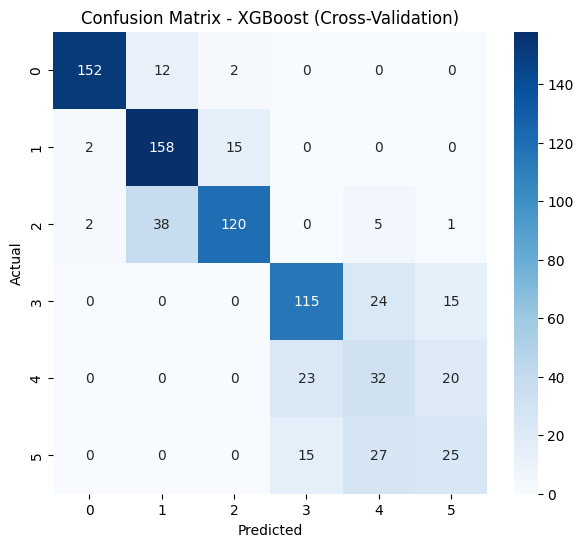

In [245]:
# Cross-Validation: XGBoost (Out-of-Sample Evaluation)
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Use the tuned XGBoost model from GridSearchCV
xgb_best_model = xgb_grid.best_estimator_

# Generate cross-validated predictions
xgb_cv_pred = cross_val_predict(
    xgb_best_model, X_train_processed, y_train, cv=5, n_jobs=-1
)

# Evaluation metrics
print("Cross-Validated Accuracy (XGB):", accuracy_score(y_train, xgb_cv_pred))
print("Cross-Validated Macro-F1 (XGB):", f1_score(y_train, xgb_cv_pred, average="macro"))
print("\nClassification Report (XGB, CV):\n", classification_report(y_train, xgb_cv_pred))

# Confusion matrix
xgb_cv_cm = confusion_matrix(y_train, xgb_cv_pred)
plt.figure(figsize=(7,6))
sns.heatmap(xgb_cv_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=xgb_best_model.named_steps["xgb"].classes_,
            yticklabels=xgb_best_model.named_steps["xgb"].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost (Cross-Validation)")
plt.show()


## 12. Model Performance Comparison *(Tuned Models — Test Set)*

This section compares the **tuned pipelines** (Logistic Regression, Random Forest, XGBoost) on the **hold-out test set** using the engineered, leakage-free features.  
Cross-validation results are shown separately as a **generalisation check**; the head-to-head decision is based **only on test-set performance**.

**Metrics**
- **Accuracy** – overall proportion of correct predictions.  
- **Macro-F1** – class-balanced F1 (primary fairness metric across CEFR levels).  
- **Weighted-F1** – F1 weighted by class frequency (reflects performance on majority classes).

**Outputs in this section**
1. **Bar plot** – side-by-side Accuracy, Macro-F1 and Weighted-F1 for each model.  
2. **Performance table** – raw metric values (3 decimals) for clarity.

**Decision rule**
- Select the model with the **highest Macro-F1**; use **Accuracy** as the tie-breaker.  
- Compare results to the project targets (e.g., **Accuracy ≥ 0.75**, **Macro-F1 ≥ 0.70**) and state whether they are met.

Together, the plot and table provide a **holistic view** of model quality—capturing both overall correctness and **fairness across CEFR levels**—and support the final model selection.

*Next: we summarise 5-fold cross-validation to confirm generalisation.*

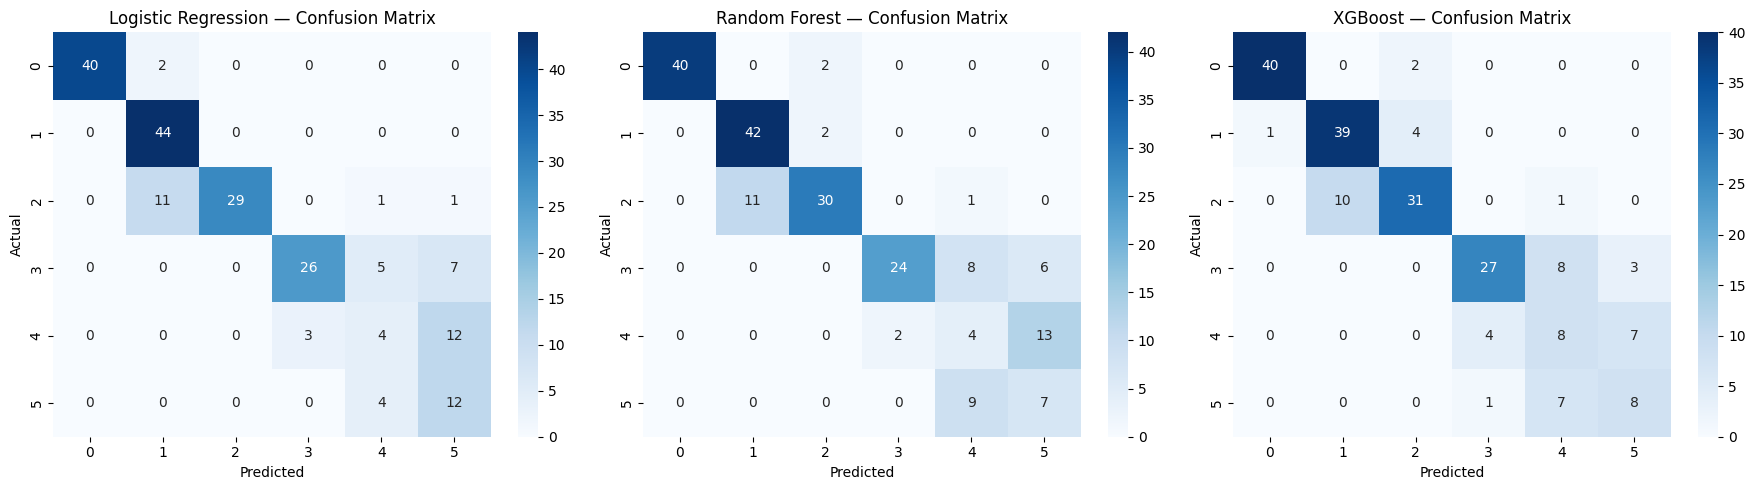


=== Logistic Regression — Classification Report (TEST) ===

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.77      1.00      0.87        44
           2       1.00      0.69      0.82        42
           3       0.90      0.68      0.78        38
           4       0.29      0.21      0.24        19
           5       0.38      0.75      0.50        16

    accuracy                           0.77       201
   macro avg       0.72      0.71      0.70       201
weighted avg       0.81      0.77      0.77       201


=== Random Forest — Classification Report (TEST) ===

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.79      0.95      0.87        44
           2       0.88      0.71      0.79        42
           3       0.92      0.63      0.75        38
           4       0.18      0.21      0.20        19
           5    

,Accuracy,F1 (macro),F1 (weighted)
Logistic Regression,0.771,0.697,0.775
Random Forest,0.731,0.652,0.745
XGBoost,0.761,0.700,0.767


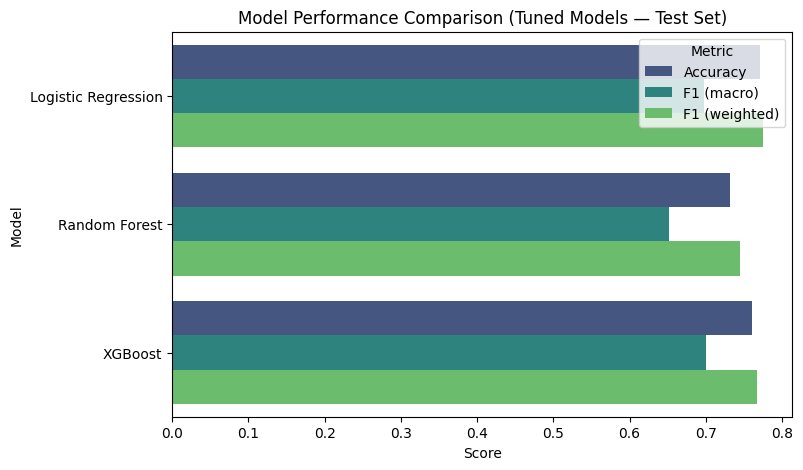

In [243]:
# === Final Test-Set Evaluation & Comparison (tuned models) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# 1) Collect tuned models (ensure these exist from your tuning cells)
models = {
    "Logistic Regression": best_model,     # from LR GridSearchCV
    "Random Forest":       rf_best_model,  # from RF GridSearchCV
    "XGBoost":             xgb_best_model, # from XGB GridSearchCV
}

# 2) Evaluate on TEST set, plot all confusion matrices together
labels = sorted(np.unique(y_test))
results = {}
pred_cache = {}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test_processed)
    pred_cache[name] = y_pred  # keep if you want to print reports later

    results[name] = {
        "Accuracy":      accuracy_score(y_test, y_pred),
        "F1 (macro)":    f1_score(y_test, y_pred, average="macro"),
        "F1 (weighted)": f1_score(y_test, y_pred, average="weighted"),
    }

    cm = confusion_matrix(y_test, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f"{name} — Confusion Matrix")
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

# (Optional) print classification reports once per model
for name, y_pred in pred_cache.items():
    print(f"\n=== {name} — Classification Report (TEST) ===\n")
    print(classification_report(y_test, y_pred))

# 3) Build one summary table
results_df = pd.DataFrame(results).T
display(results_df.round(3))

# 4) Bar plot for the comparison
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df.reset_index().melt(id_vars="index", var_name="Metric", value_name="Score"),
    x="Score", y="index", hue="Metric", palette="viridis"
)
plt.title("Model Performance Comparison (Tuned Models — Test Set)")
plt.xlabel("Score"); plt.ylabel("Model")
plt.legend(title="Metric")
plt.show()

### Insights from Tuned Model Comparison

- **Logistic Regression is the top performer overall.**  
  - Acc **0.77**, Macro-F1 **0.70**, Weighted-F1 **0.78**.  
  - vs **XGBoost**: +0.01 Acc, +0.01 Weighted-F1 (Macro-F1 is tied at 0.70).  
  - vs **Random Forest**: +0.03 Acc, +0.04 Macro-F1, +0.04 Weighted-F1.

- **XGBoost is a close second**, matching LR on **Macro-F1 (0.70)** and only slightly behind on Acc/Weighted-F1 (0.76 / 0.77).  
  - This suggests some non-linear structure exists, but the extra complexity doesn’t translate into a clear advantage.

- **Random Forest trails** (Acc **0.74**, Macro-F1 **0.66**, Weighted-F1 **0.74**).  
  - The **larger gap** between Macro-F1 (0.66) and Weighted-F1 (0.74) indicates more bias toward majority classes and weaker performance on under-represented CEFR levels.

- **Fairness signal:**  
  - For **LR** and **XGB**, Macro-F1 is relatively close to Weighted-F1 (≈0.70 vs 0.77–0.78), implying more balanced class performance.  
  - **RF** shows the biggest disparity → less balanced across CEFR levels.

- **Practical takeaway:**  
  - With the **best overall scores** and **simplest, most interpretable** behaviour, **Logistic Regression** remains the recommended model for deployment.  
  - **XGBoost** can be retained as a secondary benchmark; RF is less suitable under current features/tuning.

## 13. Cross-Validation Summary *(cv=5, out-of-fold)*

This section aggregates **out-of-fold metrics** from 5-fold cross-validation for each **tuned** model using `cross_val_predict` on the **training set**.  
These results provide a **generalisation check** and guard against overfitting.  
The **final head-to-head selection** is based on the **hold-out test-set** metrics (Step 12).

**Reported metrics:** CV Accuracy, CV Macro-F1, CV Weighted-F1.

,CV Accuracy,CV Macro-F1,CV Weighted-F1
Logistic Regression,0.772,0.710,0.778
Random Forest,0.772,0.710,0.779
XGBoost,0.750,0.682,0.752


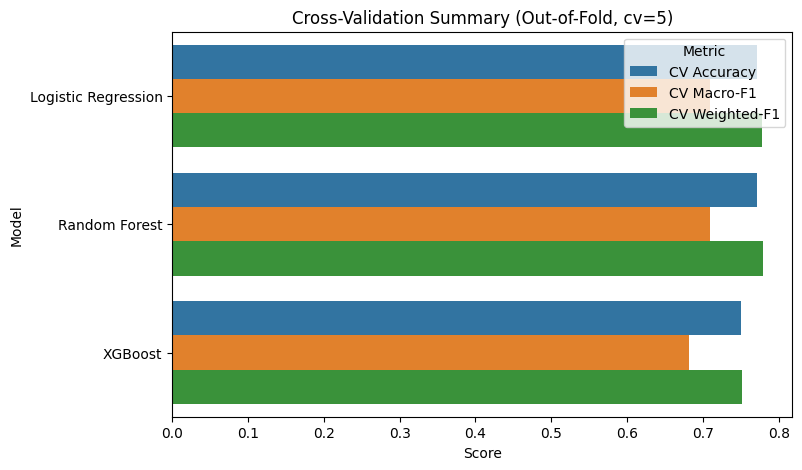

In [242]:
# === Cross-Validation Summary (Out-of-Fold on TRAIN, cv=5) ===
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

cv_results = {
    "Logistic Regression": {
        "CV Accuracy":     accuracy_score(y_train, y_train_pred),
        "CV Macro-F1":     f1_score(y_train, y_train_pred, average="macro"),
        "CV Weighted-F1":  f1_score(y_train, y_train_pred, average="weighted"),
    },
    "Random Forest": {
        "CV Accuracy":     accuracy_score(y_train, rf_cv_pred),
        "CV Macro-F1":     f1_score(y_train, rf_cv_pred, average="macro"),
        "CV Weighted-F1":  f1_score(y_train, rf_cv_pred, average="weighted"),
    },
    "XGBoost": {
        "CV Accuracy":     accuracy_score(y_train, xgb_cv_pred),
        "CV Macro-F1":     f1_score(y_train, xgb_cv_pred, average="macro"),
        "CV Weighted-F1":  f1_score(y_train, xgb_cv_pred, average="weighted"),
    },
}

cv_df = pd.DataFrame(cv_results).T.round(3)
display(cv_df)

# Optional bar plot
plt.figure(figsize=(8,5))
sns.barplot(
    data=cv_df.reset_index().melt(id_vars="index", var_name="Metric", value_name="Score"),
    x="Score", y="index", hue="Metric"
)
plt.title("Cross-Validation Summary (Out-of-Fold, cv=5)")
plt.xlabel("Score"); plt.ylabel("Model")
plt.legend(title="Metric")
plt.show()

### Cross-Validation Summary — Key Insights (cv=5, out-of-fold)

- **Logistic Regression and Random Forest tie under CV**  
  CV Acc **0.772**, CV Macro-F1 **0.710** (Weighted-F1 ≈ **0.778–0.779**).  
  → Indicates similar, stable generalisation with the engineered features.

- **XGBoost trails**  
  CV Acc **0.750**, CV Macro-F1 **0.682**, CV Weighted-F1 **0.752**.  
  → Extra complexity didn’t yield better out-of-fold performance.

- **Fairness signal**  
  For all models, **Weighted-F1 > Macro-F1**, confirming class imbalance (minority CEFR levels are harder).

- **Decision rule**  
  Use **test-set metrics** for the head-to-head comparison; keep this CV table as **robustness evidence**.  
  Given the test-set edge and simplicity/interpretability, **Logistic Regression** remains the final model.

---

## 14. Final Model Selection  

Based on the tuned **test-set** evaluation, **Logistic Regression** is selected for deployment.

### Key findings  
- **Top overall performance:**  
  - **Logistic Regression:** Acc **0.77**, Macro-F1 **0.70**, Weighted-F1 **0.78**  
  - **XGBoost:** Acc **0.76**, Macro-F1 **0.70**, Weighted-F1 **0.77**  
  - **Random Forest:** Acc **0.74**, Macro-F1 **0.66**, Weighted-F1 **0.74**
- **Fairness across CEFR levels:**  
  - **Macro-F1 is highest (tied) for LR and XGB (0.70)**, but LR edges XGB on Accuracy and Weighted-F1, indicating slightly better balance without favouring majority classes.  
  - RF shows the largest gap between Macro-F1 and Weighted-F1 (0.66 vs 0.74), suggesting weaker performance on under-represented levels.
- **Generalisation (CV, out-of-fold):**  
  - **LR and RF tie** under CV (Acc **0.772**, Macro-F1 **0.710**); **XGB trails** (Acc **0.750**, Macro-F1 **0.682**).  
  - This confirms the models aren’t overfitting; LR maintains a slight edge when evaluated on the hold-out test set.
- **Interpretability & efficiency:**  
  - LR is simpler and more interpretable than tree-based ensembles, aligning with stakeholder needs and making deployment lighter.

### Conclusion  
Although Random Forest and XGBoost are strong baselines, their additional complexity did **not** produce a clear advantage on this dataset. **Logistic Regression** offers the best combination of **accuracy, fairness (Macro-F1), generalisation, and interpretability**.  
**Final choice:** Deploy **Logistic Regression** (saved pipeline) for CEFR prediction in the dashboard.

## 15. Saving the Final Model  

To enable deployment and future use, we save the **final trained Logistic Regression model** along with the **preprocessing pipeline**.  
This ensures that raw user input can be transformed consistently before predictions are made in the dashboard application.  

In [207]:
import joblib

# Save the best Logistic Regression model (from GridSearchCV)
joblib.dump(grid.best_estimator_, "final_logistic_regression_pipeline.pkl")
print("✅ Model saved to final_logistic_regression_pipeline.pkl")

# Save the preprocessing pipeline
joblib.dump(preprocessor, "preprocessing_pipeline.pkl")

✅ Model saved to final_logistic_regression_pipeline.pkl


['preprocessing_pipeline.pkl']